In [1]:
from osirisl1services.readlevel1 import open_level1_ir
from osirisl1services.services import Level1Services
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

In [2]:
channel = 2
orbit = 6434
ir = open_level1_ir(orbit, channel, valid=False)
num2date(ir.mjd[0],units)

datetime.datetime(2002, 4, 29, 12, 1, 35, 573189)

In [3]:
im_lst = np.arange(1500,1800,30)
pix_lst = np.arange(22, 128)

label_interval = 10

len(im_lst)

10

In [4]:
tan_alt = ir.l1.altitude
tan_lat = ir.l1.latitude
tan_lon = ir.l1.longitude
sc_look = ir.l1.look_ecef
sc_pos = ir.l1.position_ecef
l1 = ir.data
mjd = ir.mjd.data

#====drop data below and above some altitudes
l1 = l1.where(tan_alt<110e3).where(tan_alt>60e3)

## altitude space plot

/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


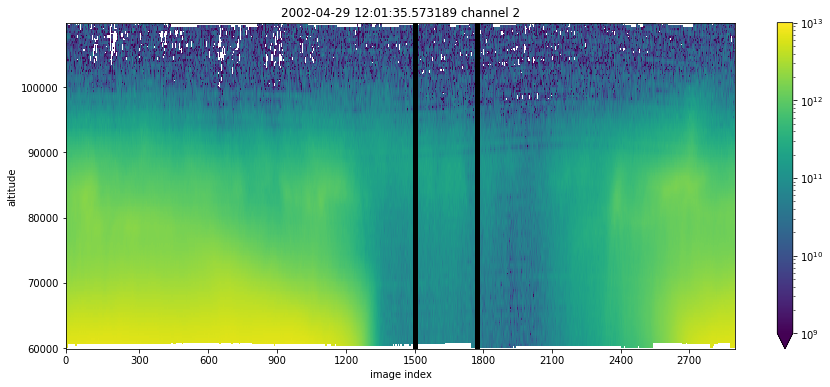

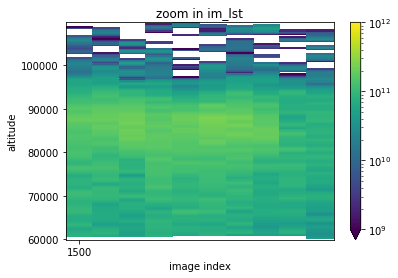

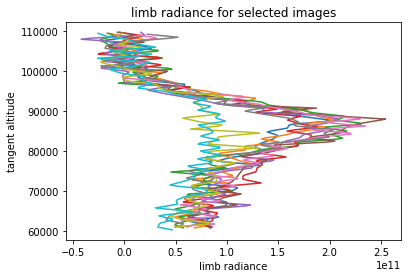

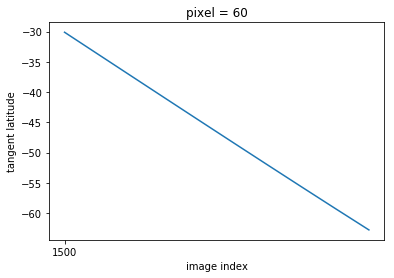

In [5]:
#%% interpolation 
alts_interp = np.arange(60e3, 110e3, .25e3)
data_interp = []


for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=[l1.mjd, alts_interp],
                           dims=['mjd', 'altitude'])

#%%plotting
plt.figure(figsize=(15,6))
data_interp.plot(x='mjd', y='altitude',
                 norm=LogNorm(), vmin=1e9, vmax=1e13)
plt.title(str(num2date(ir.mjd[0],units))+' channel '+str(channel))
plt.axvline(x=mjd[im_lst[0]], color='k', linewidth=5)
plt.axvline(x=mjd[im_lst[-1]], color='k', linewidth=5)
ax = plt.gca()
ax.set_xticks(mjd[np.arange(0,len(mjd),300, dtype=int)])
ax.set_xticklabels(np.arange(0,len(mjd),300))
ax.set(xlabel='image index')
plt.show()


plt.figure()
data_interp.isel(mjd=im_lst).plot(x='mjd', y='altitude', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e12)#, 
                 #size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst',
      xlabel='image index')
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
plt.show()

plt.figure()
plt.plot(data_interp.isel(mjd=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images')

plt.figure()
tan_lat.isel(mjd=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
ax.set(xlabel='image index',
      ylabel='tangent latitude')
plt.show()


## clip and flatten data

In [6]:
tan_alt = ir.l1.altitude
tan_lat = ir.l1.latitude
tan_lon = ir.l1.longitude
sc_look = ir.l1.look_ecef
sc_pos = ir.l1.position_ecef
l1 = ir.data

#====drop data below and above some altitudes
l1 = l1.where(tan_alt<110e3).where(tan_alt>60e3)

measurements = l1.isel(mjd=im_lst, pixel=pix_lst).stack(msure=('mjd', 'pixel')).dropna('msure')
sc_look = sc_look.isel(pixel=pix_lst).stack(msure=('mjd', 'pixel')).sel(msure=measurements.msure).T
sc_pos = sc_pos.sel(mjd=measurements.mjd)
tan_lat = tan_lat.isel(mjd=im_lst, pixel=pix_lst).stack(msure=('mjd', 'pixel')).sel(msure=measurements.msure)
tan_lon = tan_lon.isel(mjd=im_lst, pixel=pix_lst).stack(msure=('mjd', 'pixel')).sel(msure=measurements.msure)
tan_alt = tan_alt.isel(mjd=im_lst, pixel=pix_lst).stack(msure=('mjd', 'pixel')).sel(msure=measurements.msure)

## 1D inversion

/home/anqil/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


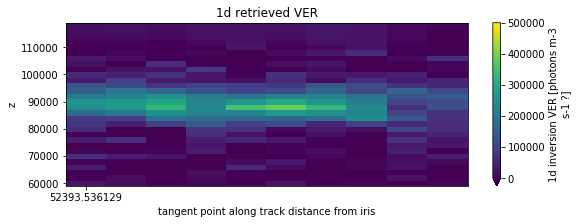

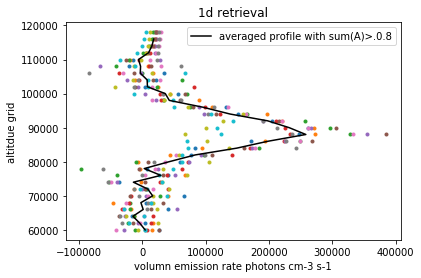

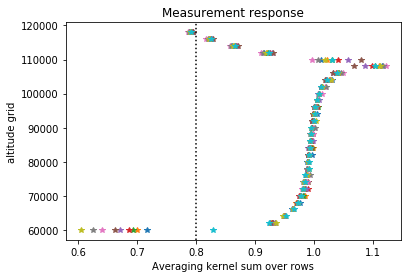

<Figure size 432x288 with 0 Axes>

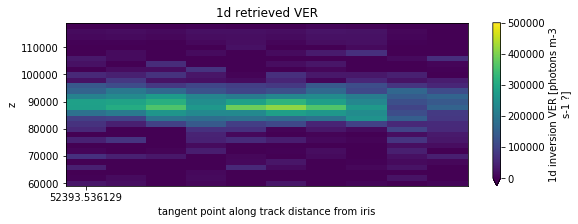

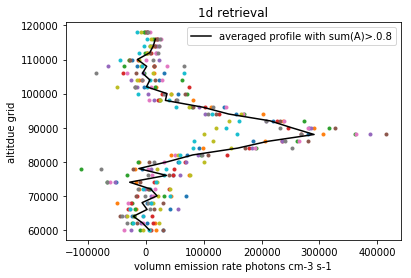

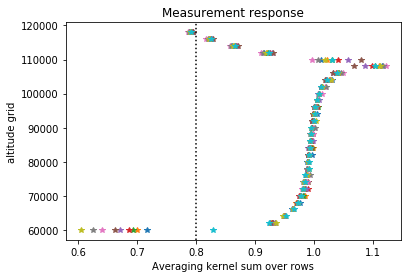

In [7]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(60e3, 120e3, 2e3) # m
z_top = z[-1] + 2e3
result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) * 0 # temp
Sa = np.diag(np.ones(len(z)))*1e10
#Se = np.diag(np.ones(len(pixel))) * (2.5e10)**2# 1e10 #30 #temporary
Ave = []
residual = []
for i in range(len(im_lst)):
    h = tan_alt.unstack('msure').isel(mjd=i).dropna('pixel').data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(mjd=im_lst[i]).dropna('pixel').data  
    Se = np.diag(np.ones(len(y))) * (2.5e10)**2# 1e10 #30 #temporary
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 
    residual.append(y-K.dot(x))

result_1d = xr.DataArray(result_1d, 
                         coords=(mjd[im_lst], z), 
                         dims=('mjd', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
mr_threshold = 0.8
result_1d_mean = result_1d.where(Ave>mr_threshold).mean(dim='mjd')


# plot VER results
result_1d.plot(x='mjd', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=5e5, 
         cmap = 'viridis',
         size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='tangent point along track distance from iris')
ax.set_xticks(mjd[im_lst[::label_interval]])
#ax.set_xticklabels(np.round(tan_beta.sel(pixel=60).data[::label_interval]*Re))
plt.show()

plt.figure()
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with sum(A)>.{}'.format(mr_threshold))
ax.set_xscale('linear')
ax.set(#xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend()
plt.show()

# plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('Averaging kernel sum over rows')
plt.ylabel('altitude grid')
plt.title('Measurement response')
#plt.xlim([mr_threshold, 1.2])
plt.axvline(x=mr_threshold, ls=':', color='k')
#plt.text(mr_threshold, z[-1], 'threshold')
plt.show()


#==== invert once more
result_1d_pre = result_1d
result_1d_mean_pre = result_1d_mean
xa = result_1d_mean_pre.fillna(0).data
Ave = []
residual = []
for i in range(len(im_lst)):
    h = tan_alt.unstack('msure').isel(mjd=i).dropna('pixel').data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(mjd=im_lst[i]).dropna('pixel').data  
    Se = np.diag(np.ones(len(y))) * (2.5e10)**2# 1e10 #30 #temporary
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 
    residual.append(y-K.dot(x))
result_1d = xr.DataArray(result_1d, 
                         coords=(mjd[im_lst], z), 
                         dims=('mjd', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
result_1d_mean = result_1d.where(Ave>mr_threshold).mean(dim='mjd')


# plot VER results
plt.figure()
result_1d.plot(x='mjd', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=5e5, 
         cmap = 'viridis',
         size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='tangent point along track distance from iris')
ax.set_xticks(mjd[im_lst[::label_interval]])
#ax.set_xticklabels(np.round(tan_beta.sel(pixel=60).data[::label_interval]*Re))
plt.show()

plt.figure()
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with sum(A)>.{}'.format(mr_threshold))
ax.set_xscale('linear')
ax.set(#xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend()
plt.show()

# plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('Averaging kernel sum over rows')
plt.ylabel('altitude grid')
plt.title('Measurement response')
#plt.xlim([mr_threshold, 1.2])
plt.axvline(x=mr_threshold, ls=':', color='k')
#plt.text(mr_threshold, z[-1], 'threshold')
plt.show()


# Tomography

In [16]:
measurements
l1

<xarray.DataArray (mjd: 2901, pixel: 128)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * mjd      (mjd) float64 5.239e+04 5.239e+04 5.239e+04 ... 5.239e+04 5.239e+04
  * pixel    (pixel) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127

## change coordiante

In [9]:
#====define the new base vectors
n_crosstrack = np.cross(sc_look.isel(msure=0),
                        sc_pos.isel(msure=0))
n_vel = np.cross(sc_pos.isel(msure=0), n_crosstrack)
n_zenith = sc_pos.isel(msure=0)

#====tangent points in alpha, beta, rho coordinate
import pandas as pd
from geometry_functions import lla2ecef, cart2sphe, change_of_basis
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

tan_alpha = []
tan_beta = []
tan_rho = []
for i in range(len(measurements)):
    p_old = tan_ecef.isel(msure=i)
    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z'))
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=measurements.coords,
                         dims=measurements.dims)
tan_beta = xr.DataArray(tan_beta, 
                        coords=measurements.coords,
                        dims=measurements.dims)
tan_rho = xr.DataArray(tan_rho, 
                       coords=measurements.coords,
                       dims=measurements.dims)

Re = 6371 + 100 #Earth radius in km

In [10]:
#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 2) #radian
edges_beta = np.linspace(tan_beta.min()-0.1,
                         tan_beta.max()+0.15, 25) #radian
edges_rho = np.append(z,z_top) # meter
edges = edges_alpha, edges_beta, edges_rho

#====grid points for plotting
grid_alpha = np.append(edges_alpha - np.gradient(edges_alpha)/2, 
                       edges_alpha[-1]+np.gradient(edges_alpha)[-1]/2)
grid_beta = np.append(edges_beta - np.gradient(edges_beta)/2, 
                       edges_beta[-1]+np.gradient(edges_beta)[-1]/2)
grid_rho = np.append(edges_rho - np.gradient(edges_rho)/2, 
                       edges_rho[-1]+np.gradient(edges_rho)[-1]/2)

## Jacobian

In [17]:
from geometry_functions import los_points_fix_dl2

#====num of columns & rows of jacobian
col_len = len(grid_alpha) * len(grid_beta) * len(grid_rho)
row_len = len(measurements)

#====measure pathlength in each bin
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for i in range(len(measurements)):
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look[i].T)
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos[i])
    lx, ly, lz = los_points_fix_dl2(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    #for pix in pix_lst: 
    los = los_alpha, los_beta, los_rho
    print(i, measurement_id, los_beta.shape)
    measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
    K_row_idx.append(measurement_idx)
    K_col_idx.append(grid_idx)
    K_value.append(pathlength)
    measurement_id += 1
        
  

0 0 (500,)
1 1 (500,)
2 2 (500,)
3 3 (500,)
4 4 (500,)
5 5 (500,)
6 6 (500,)
7 7 (500,)
8 8 (500,)
9 9 (500,)
10 10 (500,)
11 11 (500,)
12 12 (500,)
13 13 (500,)
14 14 (500,)
15 15 (500,)
16 16 (500,)
17 17 (500,)
18 18 (500,)
19 19 (500,)
20 20 (500,)
21 21 (500,)
22 22 (500,)
23 23 (500,)
24 24 (500,)
25 25 (500,)
26 26 (500,)
27 27 (500,)
28 28 (500,)
29 29 (500,)
30 30 (500,)
31 31 (500,)
32 32 (500,)
33 33 (500,)
34 34 (500,)
35 35 (500,)
36 36 (500,)
37 37 (500,)
38 38 (500,)
39 39 (500,)
40 40 (500,)
41 41 (500,)
42 42 (500,)
43 43 (500,)
44 44 (500,)
45 45 (500,)
46 46 (500,)
47 47 (500,)
48 48 (500,)
49 49 (500,)
50 50 (500,)
51 51 (500,)
52 52 (500,)
53 53 (500,)
54 54 (500,)
55 55 (500,)
56 56 (500,)
57 57 (500,)
58 58 (500,)
59 59 (500,)
60 60 (500,)
61 61 (500,)
62 62 (500,)
63 63 (500,)
64 64 (500,)
65 65 (500,)
66 66 (500,)
67 67 (500,)
68 68 (500,)
69 69 (500,)
70 70 (500,)
71 71 (500,)
72 72 (500,)
73 73 (500,)
74 74 (500,)
75 75 (500,)
76 76 (500,)
77 77 (500,)
78 78 

KeyboardInterrupt: 

In [ ]:
      
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))

## Tomo inversion

In [ ]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
y = l1.isel(mjd=im_lst, pixel=pix_lst).data.ravel()
y[y<0] = 0 #temp
#xa = np.ones(col_len) # temp
xa = interp1d(z, result_1d_mean.data, fill_value='extrapolate')(grid_rho)
xa = np.tile(xa, (len(grid_alpha),len(grid_beta),1)).ravel()
Sa = sp.diags([1], shape=(col_len, col_len)) * (2e4)**2 #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id)) * (1e9)**2 #temp
x_hat, G = linear_oem_sp(K_coo, Se, Sa, y, xa)

shape_tomo = (len(grid_alpha), len(grid_beta), len(grid_rho))
result_tomo = x_hat.reshape(shape_tomo)
result_tomo = xr.DataArray(result_tomo, 
                           coords=(grid_alpha, grid_beta, grid_rho), 
                           dims=('alpha', 'beta', 'rho')) #temp

%matplotlib inline
#====check residual
zoom = np.arange(1000)
plt.figure()
plt.plot(y[zoom], label='y')
plt.plot(K_coo.dot(x_hat)[zoom], label='K*x_hat')
plt.ylabel('signal')
plt.legend()
plt.show()


#====check residual
plt.figure()
plt.plot(K_coo.dot(x_hat)[zoom]-y[zoom])
plt.ylabel('residual')
plt.show()


#====contour plot 
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.pcolor(grid_beta*Re, grid_rho*1e-3, result_tomo.isel(alpha=1).T)
ax.set(xlabel='distance along track in km',
       ylabel='altitude in km',
       title='slice along track')
plt.colorbar()
for i in range(0,len(im_lst),1):
    plt.axvline(x=tan_beta.sel(pixel=60)[i].data*Re, ymin=0.9)
plt.show()


#==== vertical profiles within the 3D matrix
plt.figure()
fig, ax = plt.subplots()
ax.set_xscale('linear')
ax.set(xlabel='VER',
      ylabel='altitude',
      title='tomography VER (all columns along track)')
for i in range(1,len(grid_alpha)-1):
    for j in range(1, len(grid_beta)-1):
        ax.plot(result_tomo[i,j,:], grid_rho*1e-3, '-')
plt.show()